In [13]:
import numpy as np
import xray
import os, psutil
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from matplotlib.ticker import LogFormatter, LogFormatterMathtext 
%matplotlib inline

plt.rcParams['figure.figsize'] = (12,7)
plt.rcParams['image.origin'] = 'bottom'

print xray

<module 'xray' from '/home/rpa/xray/xray/__init__.pyc'>


In [14]:
ddir = '/data/scratch/rpa/aviso/ftp.aviso.altimetry.fr/global/delayed-time/grids/msla/all-sat-merged'

In [15]:
# shows that the smallest chunk is fastest
FILTER_STDDEV=2

cs = 1
eke_monthly_ds = xray.open_dataset(
    os.path.join(ddir,'uv','ekea_monthly_mean_filtered-%g.nc' % FILTER_STDDEV), chunks={'time':cs},)
    #engine='scipy')
ekem = eke_monthly_ds.eke
eke_by_month = ekem.groupby('time.month').mean('time')
eke_annmean = ekem.mean(dim='time')
eke_month_anom = eke_by_month - eke_annmean

In [16]:
%time eke_annmean.load()
%time eke_month_anom.load()

CPU times: user 7.36 s, sys: 3.18 s, total: 10.5 s
Wall time: 4.36 s
CPU times: user 20.2 s, sys: 6.36 s, total: 26.6 s
Wall time: 6.07 s


<xray.DataArray 'eke' (month: 12, lat: 720, lon: 1440)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,

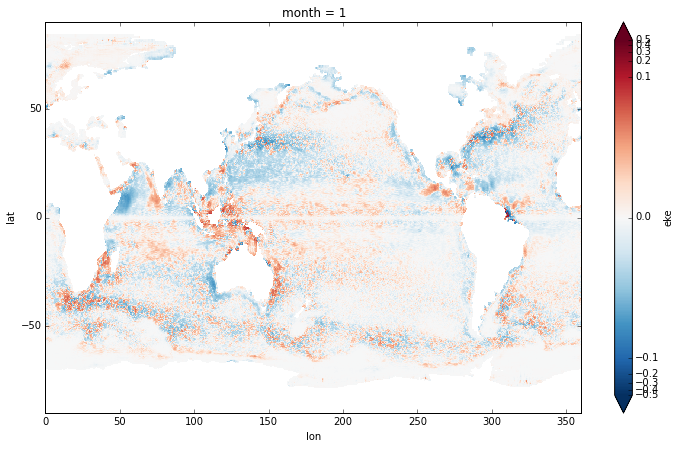

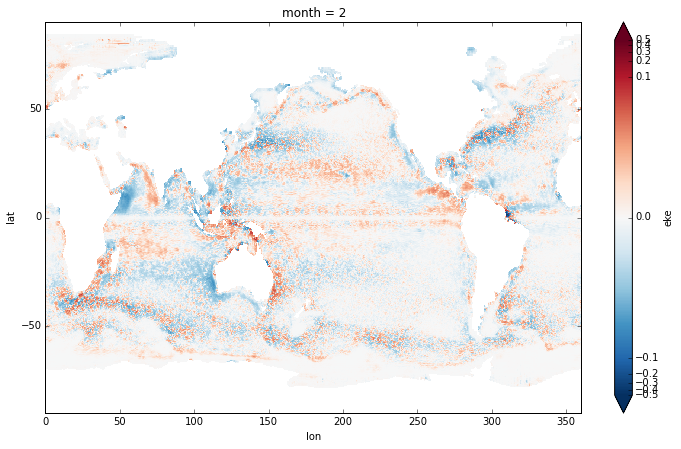

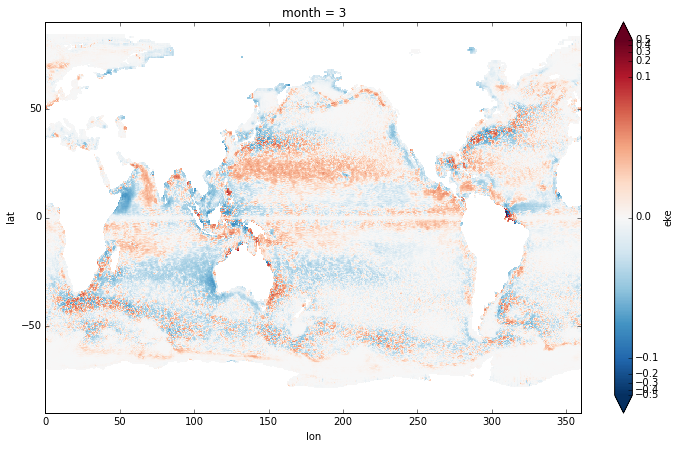

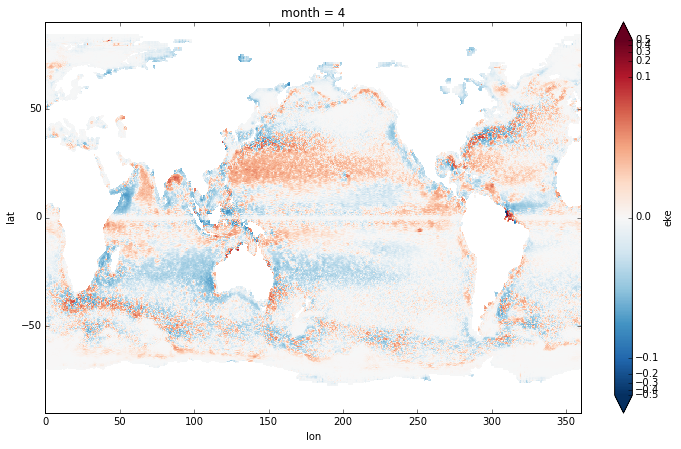

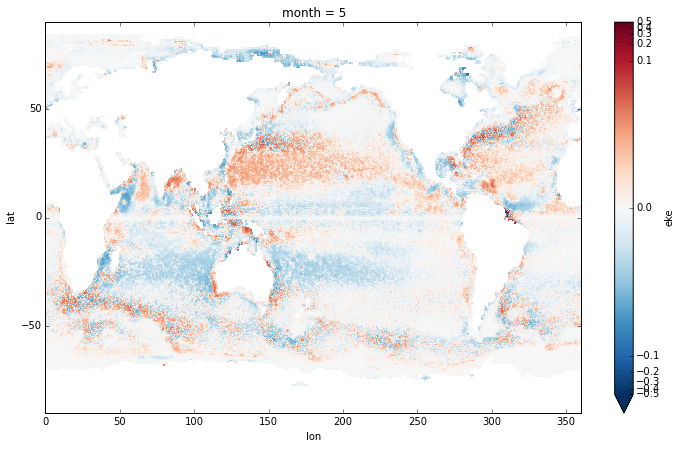

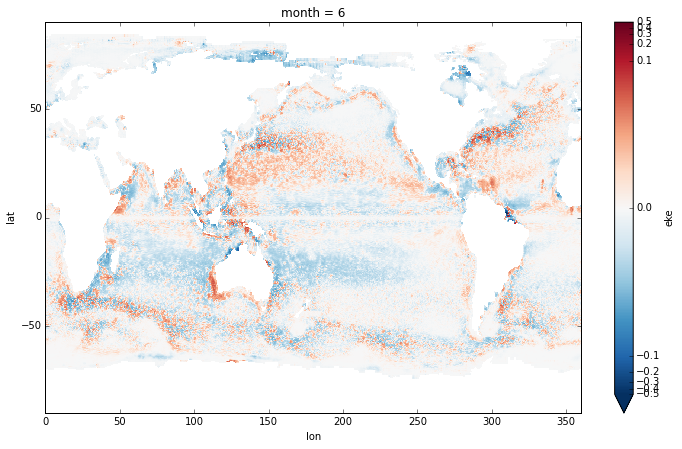

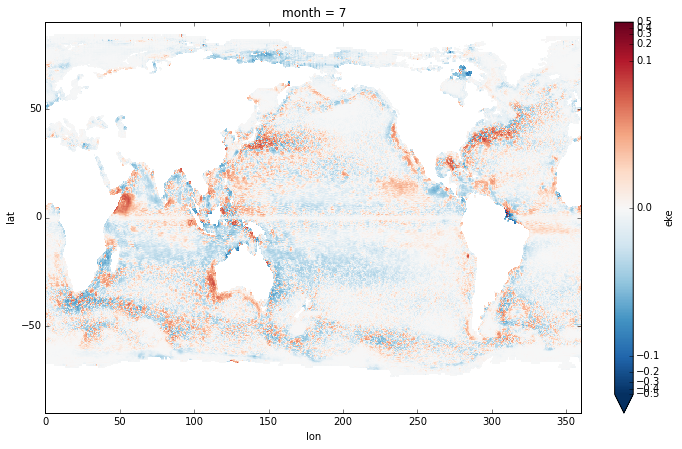

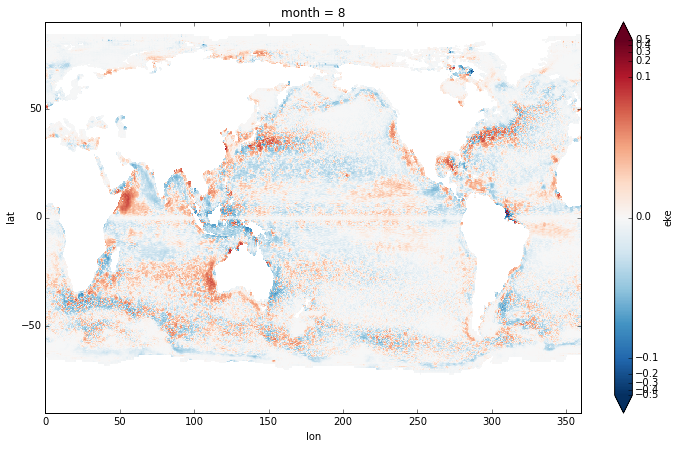

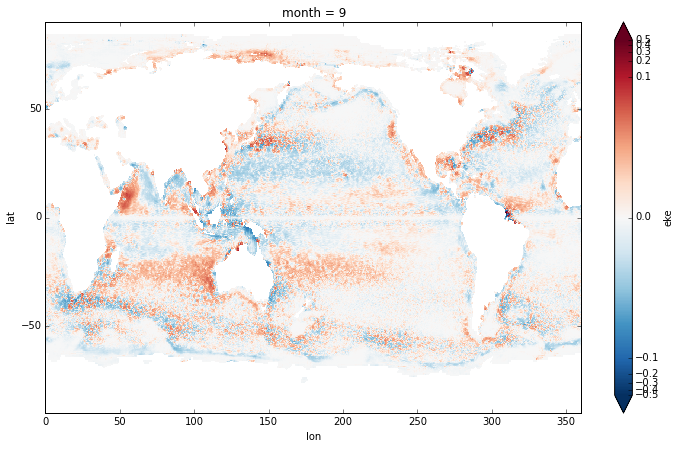

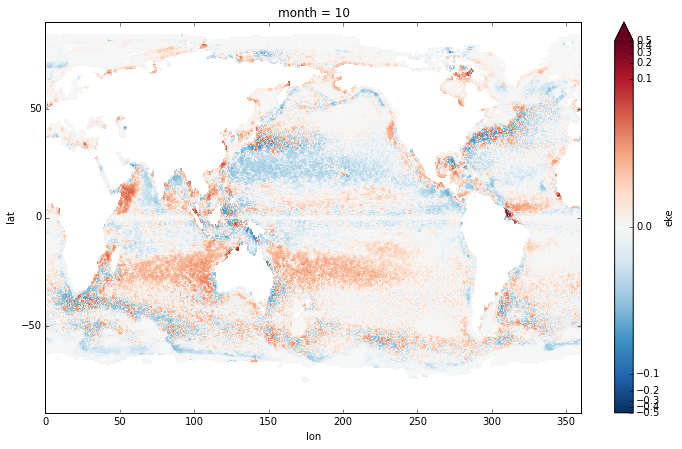

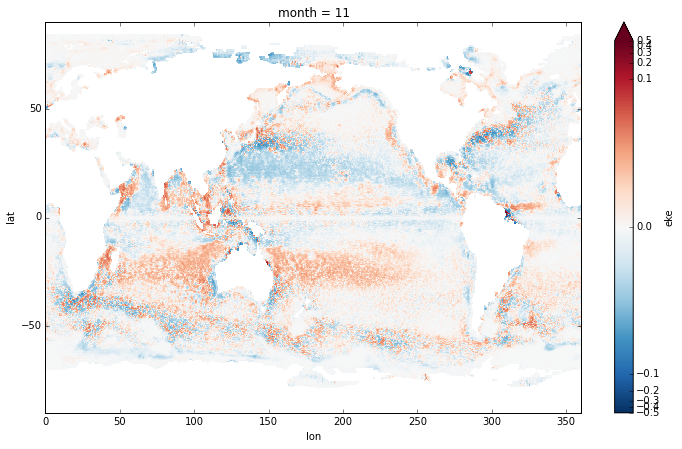

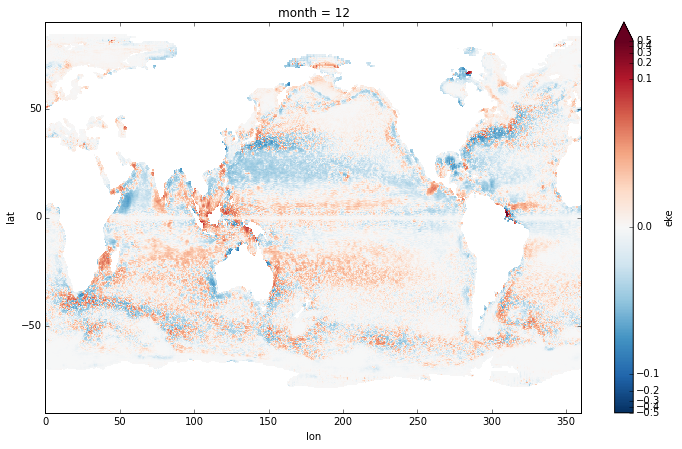

In [19]:
from matplotlib.colors import SymLogNorm
ekemax=0.5
for month in range(12):
    plt.figure()
    eke_month_anom[month].plot.pcolormesh(
            norm=SymLogNorm(1e-3), vmin=-ekemax, vmax=ekemax)

In [20]:
eke_so = ekem.sel(lat=slice(-90,-30))
eke_so_annmean = eke_so.groupby('time.year').mean()
eke_so_annstd = eke_so.groupby('time.year').std()
N = eke_so[0].size

eke_so_annmean.load()
eke_so_annstd.load()

<xray.DataArray 'eke' (year: 22)>
array([ 0.01090026,  0.01003652,  0.01052516,  0.0102612 ,  0.01066101,
        0.01059817,  0.01101256,  0.01074336,  0.01087428,  0.01031589,
        0.01053903,  0.01087985,  0.0105385 ,  0.01083185,  0.01090338,
        0.01083085,  0.01072045,  0.01076043,  0.01077381,  0.01019608,
        0.01120115,  0.01116193])
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 ...

<Container object of 3 artists>

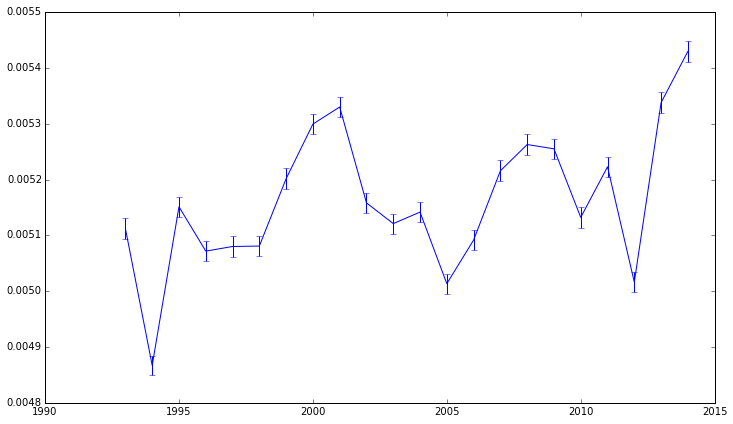

In [21]:
plt.errorbar(eke_so_annmean.year, eke_so_annmean, yerr=eke_so_annstd/N**0.5)

In [7]:
from astropy.convolution import Gaussian2DKernel, convolve
from mpl_toolkits.basemap import Basemap
m = Basemap('robin')
    
def map_pcolor(da, smooth=None, **kwargs):
    m = Basemap(projection='robin', lon_0=180)
    ax = plt.gca()
    ax.set_axis_bgcolor('0.5')
    m.fillcontinents(color='0.5')
    lon, lat = np.meshgrid(np.asarray(da['lon']), np.asarray(da['lat']))
    dat = np.asarray(da)
    mask = np.isnan(dat)
    if smooth is not None:
        ker = Gaussian2DKernel(smooth)
        dat = convolve(dat, ker)
    return m, m.pcolormesh(lon, lat, np.ma.masked_array(dat, mask),
                           latlon=True, **kwargs)
    

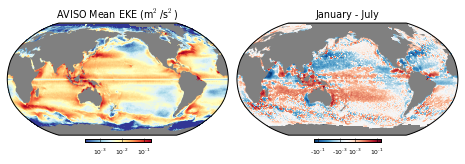

In [9]:
plt.rcParams['font.size'] = 8
plt.figure(figsize=(6.5,3))

plt.subplot(121)
m, pc = map_pcolor(eke_annmean, 2, norm=LogNorm(), cmap='RdYlBu_r', rasterized=True)
plt.clim([2e-4,2e-1])
plt.title('AVISO Mean EKE (m$^2$/s$^2$)')
cb1 = plt.colorbar(shrink=0.3, pad=0.02, orientation='horizontal')
cb1.ax.tick_params(labelsize=6)


plt.subplot(122)
m, pc = map_pcolor(eke_jan_minus_july, 2, cmap='RdBu_r',
                   norm=SymLogNorm(1e-3), rasterized=True)
plt.clim([-2e-1,2e-1])
plt.title('January - July')
cb2 = plt.colorbar(ticks=[-1e-1, -1e-3, 1e-3, 1e-1], format=LogFormatterMathtext(),
    shrink=0.3, pad=0.02, orientation='horizontal')
cb2.ax.tick_params(labelsize=6)

plt.tight_layout()
plt.savefig('figures/EKE_filter-%g.pdf' % FILTER_STDDEV)

In [14]:
da = eke_annmean
dat = np.asarray(da)
mask = np.isnan(dat)
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

<matplotlib.colorbar.Colorbar instance at 0x7fa79e0c1128>

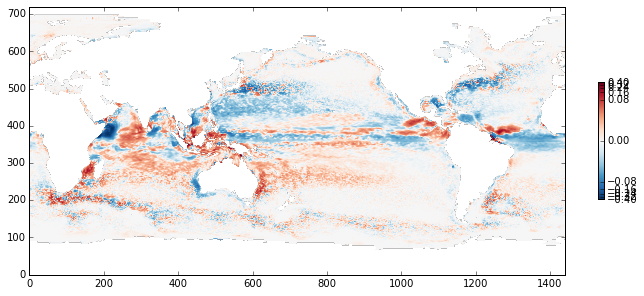

In [110]:
plt.imshow(eke_jan_minus_july, cmap='RdBu_r', norm=SymLogNorm(1e-2))
plt.clim([-0.4,0.4])
plt.colorbar(shrink=0.3)

In [23]:
eke_so

<xray.DataArray 'eke' (time: 264, lat: 240, lon: 1440)>
dask.array<x_6051, shape=(264, 240, 1440), chunks=((12, 12, 12, ..., 12, 12), (240,), (1440,)), dtype=float64>
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 1993-03-01 ...

In [24]:
240 *1440 

345600

In [132]:
ds['u'][0]

<xray.DataArray 'u' (lat: 720, lon: 1440)>
dask.array<x_8923, shape=(720, 1440), chunks=((720,), (1440,)), dtype=float64>
Coordinates:
    time     datetime64[ns] 1993-01-01
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
Attributes:
    units: m/s
    standard_name: surface_eastward_geostrophic_sea_water_velocity_assuming_sea_level_for_geoid
    long_name: Geostrophic velocity anomalies: zonal component

In [7]:
from astropy.convolution import Gaussian2DKernel, convolve


In [ ]:
gaussian_kernel = Gaussian2DKernel(stddev=6)
u = np.asarray(ds['u'][0])
v = np.asarray(ds['v'][0])
u_filt = convolve(u, gaussian_kernel, boundary='wrap')
v_filt = convolve(v, gaussian_kernel, boundary='wrap')

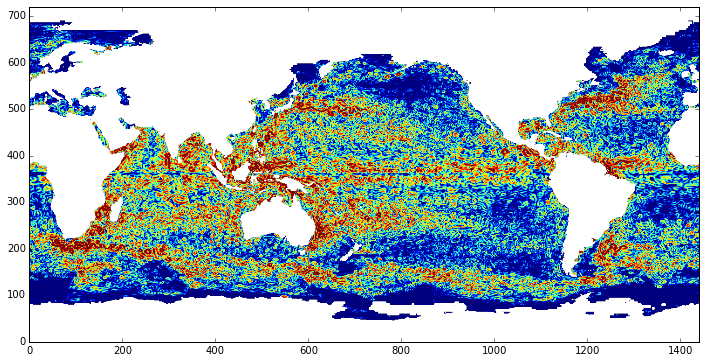

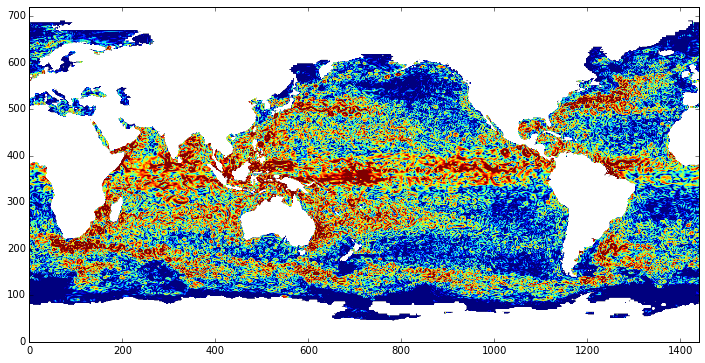

In [39]:
ke_filt = 0.5*((u-u_filt)**2 + (v-v_filt)**2)
ke_full =  0.5*(u**2 + v**2)
plt.imshow(np.log10(ke_filt))
plt.clim([-3,-1])
plt.figure()
plt.imshow(np.log10(ke_full))
plt.clim([-3,-1])


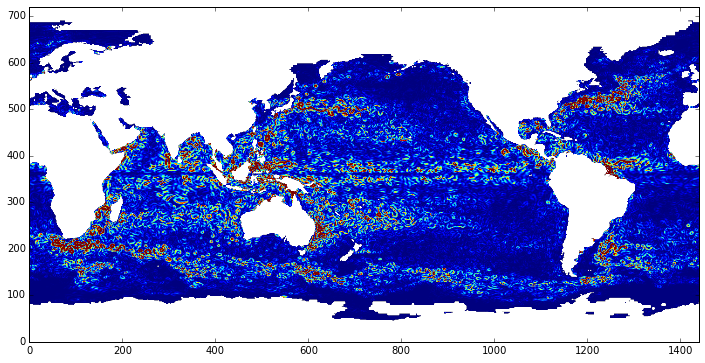

In [40]:
plt.imshow(ke_filt)
plt.clim([0, 0.1])

In [42]:
print np.ma.masked_invalid(ke_full).sum()
print np.ma.masked_invalid(ke_filt).sum()

12395.0008414
9865.77610143


In [24]:
def gaussian_filter(np_ar):
    print 'gaussian_filter'
    print ' np_ar.shape =', np_ar.shape
    gaussian_kernel = Gaussian2DKernel(stddev=2)
    if np_ar.ndim > 2:
        out = np.zeros_like(np_ar)
        for k in xrange(np_ar.shape[0]):
            print '  doing k = ', k
            out[k] = convolve(np_ar[k], gaussian_kernel, boundary='wrap')
    else:
        out = convolve(np_ar, gaussian_kernel, boundary='wrap')
    return out


In [39]:
u = ds['u']
da = u.data
res = da.map_blocks(gaussian_filter) # chunks=((1,),(720,),(1440,)))
ugf = xray.DataArray(res, dims=u.dims, coords=u.coords)
ufilt = u - ugf
ufilt

<xray.DataArray (time: 8031, lat: 720, lon: 1440)>
dask.array<x_4700, shape=(8031, 720, 1440), chunks=((31, 28, 31, ..., 30, 27), (720,), (1440,)), dtype=None>
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...

In [ ]:
ufilt.load()

In [ ]:
# filter and take monthly means
def square(fa):
    print 'square'
    return fa**2
def square_numpy(fa):
    print 'square_numpy'
    return np.asarray(fa)**2

In [26]:
u2 = ds['u'][:5].groupby('time').apply(high_pass_filter)

high_pass_filter


IndexError:  Exception in remote process

tuple index out of range

Traceback:
  File "/usr/local/anaconda/lib/python2.7/site-packages/dask/async.py", line 260, in execute_task
    result = _execute_task(task, data)
  File "/usr/local/anaconda/lib/python2.7/site-packages/dask/async.py", line 243, in _execute_task
    return func(*args2)
  File "/usr/local/anaconda/lib/python2.7/site-packages/toolz/functoolz.py", line 378, in __call__
    ret = fns[0](*args, **kwargs)
  File "/usr/local/anaconda/lib/python2.7/site-packages/dask/array/core.py", line 377, in _concatenate2
    return np.concatenate(arrays, axis=axes[0])


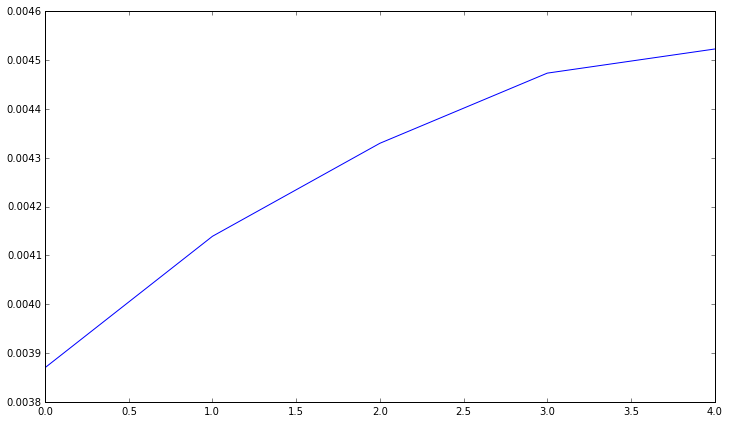

In [78]:
plt.plot(u2.mean(dim='lon').mean(dim='lat'))

In [155]:
ds.chunk({'time':1})
u = ds['u']
u.chunk({'time':1})
#res = u.data.map_blocks(gaussian_filter)

<xray.DataArray 'u' (time: 8031, lat: 720, lon: 1440)>
dask.array<rechunk-32, shape=(8031, 720, 1440), chunks=((1, 1, 1, ..., 1, 1), (720,), (1440,)), dtype=float64>
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
Attributes:
    units: m/s
    standard_name: surface_eastward_geostrophic_sea_water_velocity_assuming_sea_level_for_geoid
    long_name: Geostrophic velocity anomalies: zonal component

In [156]:
u

<xray.DataArray 'u' (time: 8031, lat: 720, lon: 1440)>
dask.array<concatenate-4, shape=(8031, 720, 1440), chunks=((31, 28, 31, ..., 30, 27), (720,), (1440,)), dtype=float64>
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
Attributes:
    units: m/s
    standard_name: surface_eastward_geostrophic_sea_water_velocity_assuming_sea_level_for_geoid
    long_name: Geostrophic velocity anomalies: zonal component

In [ ]:
xray.open_dataset(